<a href="https://colab.research.google.com/github/auab/Customer-Analysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction and import data

The idea of this project is to segmentate customers of a market based on attributes, namely personal, purchase and promotion interaction features. With the result, it is possible to create target marketing campaings and understand how each group behaves.

First, we need to import the data, available in  my github repository.

In [71]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture
import plotly.graph_objects as go
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings
warnings.filterwarnings('ignore')

In [51]:
customer_data = pd.read_csv('https://raw.githubusercontent.com/auab/Customer-Analysis/main/marketing_campaign.csv',sep='\t')
customer_data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


# 2. Analyzing the data
The next step is to visualize the data. Obsever the feature type (numerical/categorical) if there are N.A. values, outliers and possible characteristics to be explored further. But before doing it, will replace the *Year_Birth* column by the *Age* information.

In [52]:
current_year = datetime.datetime.now().year
customer_data = customer_data.apply(lambda feature: current_year - feature if feature.name == 'Year_Birth' else feature).\
                              rename(columns={'Year_Birth':'Age'})

In [53]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Age                  2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Now we'll create newfeatures to make easier the next steps

In [54]:
customer_data['Spending'] = customer_data[['MntFruits','MntWines','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)
customer_data['Seniority']=pd.to_datetime(customer_data['Dt_Customer'], dayfirst=True,format = '%d-%m-%Y')
today = datetime.date.today()
customer_data['Seniority'] = pd.to_numeric(customer_data['Seniority'].dt.date.apply(lambda x: (today - x)).dt.days, downcast='integer')/30
customer_data.rename(columns={'NumWebPurchases': "Web",'NumCatalogPurchases':'Catalog','NumStorePurchases':'Store'},inplace=True)
customer_data['Marital_Status'].replace({'Divorced':'Alone','Single':'Alone','Married':'In couple','Together':'In couple','Absurd':'Alone','Widow':'Alone','YOLO':'Alone'},inplace=True)
customer_data['Education'].replace({'Basic':'Undergraduate','2n Cycle':'Undergraduate','Graduation':'Postgraduate','Master':'Postgraduate','PhD':'Postgraduate'},inplace=True)
customer_data['Children']=customer_data[['Kidhome','Teenhome']].sum(axis=1)
customer_data['Has_child'] = np.where(customer_data['Children']> 0, 'Has child', 'No child')
customer_data=customer_data.rename(columns={'MntWines': "Wines",'MntFruits':'Fruits','MntMeatProducts':'Meat','MntFishProducts':'Fish','MntSweetProducts':'Sweets','MntGoldProds':'Gold'})

In [55]:
customer_data=customer_data[['Age','Education','Marital_Status','Income','Spending','Seniority','Has_child','Children','Wines','Fruits','Meat','Fish','Sweets','Gold']]
customer_data.head()


,Age,Education,Marital_Status,Income,Spending,Seniority,Has_child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold
0,64,Postgraduate,Alone,58138.0,1617,113.266667,No child,0,635,88,546,172,88,88
1,67,Postgraduate,Alone,46344.0,27,94.933333,Has child,2,11,1,6,2,1,6
2,56,Postgraduate,In couple,71613.0,776,101.566667,No child,0,426,49,127,111,21,42
3,37,Postgraduate,In couple,26646.0,53,95.800000,Has child,1,11,4,20,10,3,5
4,40,Postgraduate,In couple,58293.0,422,96.533333,Has child,1,173,43,118,46,27,15


The analysis show that the income column has NA, values. Since they are not so many, the treatment choosen here is simply drop the rows.

In [56]:
customer_data=customer_data.dropna(subset=['Income'])

Also, can be seen that there are some outliers in the Income column, they will also be removed in a first analysis.

In [58]:
customer_data=customer_data[customer_data['Income']<600000]

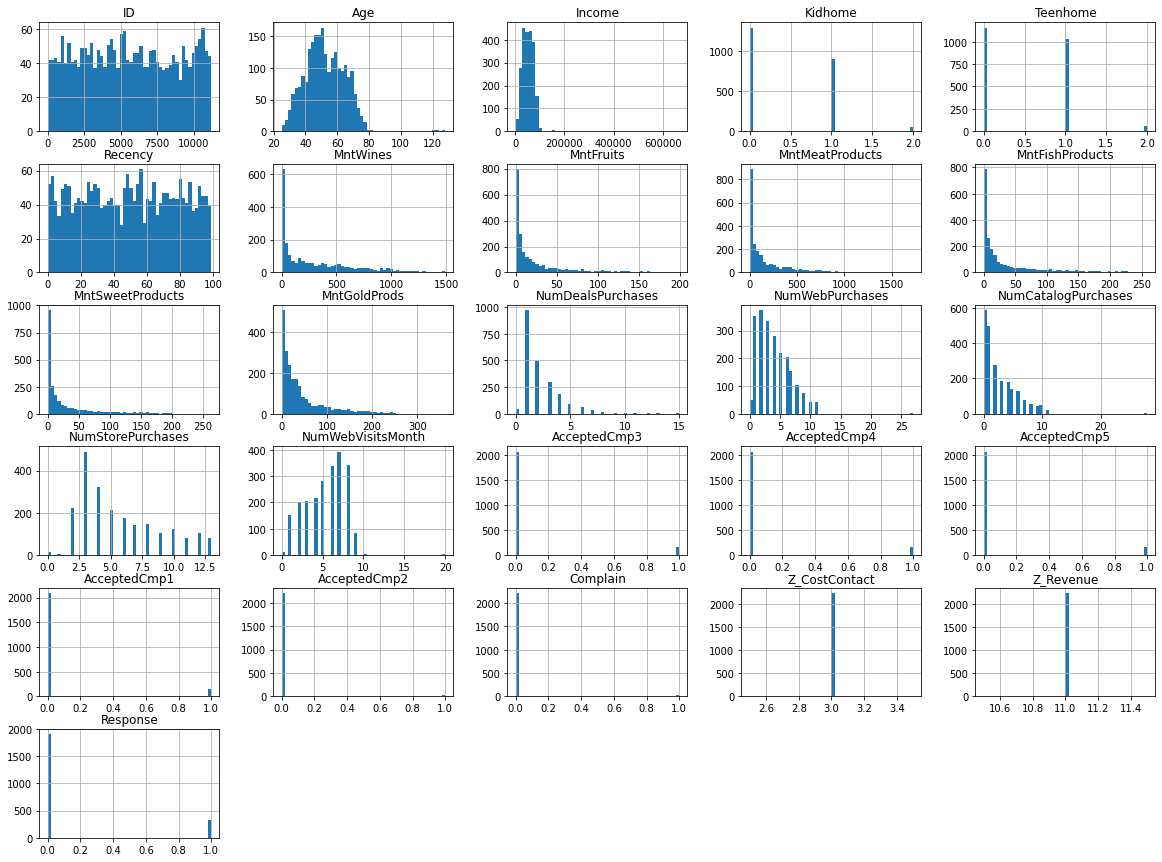

In [ ]:
customer_data.hist(bins=50, figsize=(20,15))
plt.show()

# Clustering

To take a look at the clustering of clients in the dataset, I’ll define the segments of the clients. Here we will use 4 equally weighted customer segments:

Stars: Old customers with high income and high spending nature.

Neet Attention: New customers with below-average income and low spending nature. 

High Potential: New customers with high income and high spending nature.

Leaky Bucket: Old customers with below-average income and a low spending nature.

In [61]:
scaler=StandardScaler()
dataset_temp=customer_data[['Income','Seniority','Spending']]
X_std=scaler.fit_transform(dataset_temp)
X = normalize(X_std,norm='l2')

gmm=GaussianMixture(n_components=4, covariance_type='spherical',max_iter=2000, random_state=5).fit(X)
labels = gmm.predict(X)
dataset_temp['Cluster'] = labels
dataset_temp=dataset_temp.replace({0:'Stars',1:'Need attention',2:'High potential',3:'Leaky bucket'})
customer_data = customer_data.merge(dataset_temp.Cluster, left_index=True, right_index=True)

pd.options.display.float_format = "{:.0f}".format
summary=customer_data[['Income','Spending','Seniority','Cluster']]
summary.set_index("Cluster", inplace = True)
summary=summary.groupby('Cluster').describe().transpose()
summary.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Cluster       High potential  Leaky bucket  Need attention  Stars
Income count             584           641             528    462
       mean            34757         37705           69542  73438
       std             12075         12397           12006  13753
       min              2447          1730           44802  49090
       25%             26489         28839           60880  65298

In [65]:
PLOT = go.Figure()
for C in list(customer_data.Cluster.unique()):
    

    PLOT.add_trace(go.Scatter3d(x = customer_data[customer_data.Cluster == C]['Income'],
                                y = customer_data[customer_data.Cluster == C]['Seniority'],
                                z = customer_data[customer_data.Cluster == C]['Spending'],                        
                                mode = 'markers',marker_size = 6, marker_line_width = 1,
                                name = str(C)))
PLOT.update_traces(hovertemplate='Income: %{x} <br>Seniority: %{y} <br>Spending: %{z}')

    
PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Income', titlefont_color = 'black'),
                                yaxis=dict(title = 'Seniority', titlefont_color = 'black'),
                                zaxis=dict(title = 'Spending', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

# Data Preparation for Customer Personality Analysis

Now I will prepare the data for the Apriori algorithm. Here I will be defining three segments of the customers according to the age, income and seniority:

In [67]:
#Create Age segment
cut_labels_Age = ['Young', 'Adult', 'Mature', 'Senior']
cut_bins = [0, 30, 45, 65, 120]
customer_data['Age_group'] = pd.cut(customer_data['Age'], bins=cut_bins, labels=cut_labels_Age)
#Create Income segment
cut_labels_Income = ['Low income', 'Low to medium income', 'Medium to high income', 'High income']
customer_data['Income_group'] = pd.qcut(customer_data['Income'], q=4, labels=cut_labels_Income)
#Create Seniority segment
cut_labels_Seniority = ['New customers', 'Discovering customers', 'Experienced customers', 'Old customers']
customer_data['Seniority_group'] = pd.qcut(customer_data['Seniority'], q=4, labels=cut_labels_Seniority)
customer_data=customer_data.drop(columns=['Age','Income','Seniority'])

Now I will define new segments according to the spending of customers on each product which will be based on:

Non Buyer

Low Buyer

Frequent Buyer

Biggest Buyer

In [68]:
cut_labels = ['Low consumer', 'Frequent consumer', 'Biggest consumer']
customer_data['Wines_segment'] = pd.qcut(customer_data['Wines'][customer_data['Wines']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
customer_data['Fruits_segment'] = pd.qcut(customer_data['Fruits'][customer_data['Fruits']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
customer_data['Meat_segment'] = pd.qcut(customer_data['Meat'][customer_data['Meat']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
customer_data['Fish_segment'] = pd.qcut(customer_data['Fish'][customer_data['Fish']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
customer_data['Sweets_segment'] = pd.qcut(customer_data['Sweets'][customer_data['Sweets']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
customer_data['Gold_segment'] = pd.qcut(customer_data['Gold'][customer_data['Gold']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
customer_data.replace(np.nan, "Non consumer",inplace=True)
customer_data.drop(columns=['Spending','Wines','Fruits','Meat','Fish','Sweets','Gold'],inplace=True)
customer_data = customer_data.astype(object)

# Apriori Algorithm

The Apriori algorithm is the simplest technique to identify the underlying relationships between different types of elements. The idea behind this algorithm is that all nonempty subsets of a frequent category must also be frequent. Here I will be using the Apriori algorithm for the task of customer personality analysis with Python. Here I will use this algorithm to identify the biggest customer of wines:

In [72]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 999)
pd.options.display.float_format = "{:.3f}".format
association=customer_data.copy() 
df = pd.get_dummies(association)
min_support = 0.08
max_len = 10
frequent_items = apriori(df, use_colnames=True, min_support=min_support, max_len=max_len + 1)
rules = association_rules(frequent_items, metric='lift', min_threshold=1)

product='Wines'
segment='Biggest consumer'
target = '{\'%s_segment_%s\'}' %(product,segment)
results_personnal_care = rules[rules['consequents'].astype(str).str.contains(target, na=False)].sort_values(by='confidence', ascending=False)
results_personnal_care.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9357,"(Cluster_Need attention, Education_Postgraduate, Age_group_Mature)",(Wines_segment_Biggest consumer),0.121,0.249,0.084,0.698,2.805,0.054,2.486
4858,"(Income_group_High income, Cluster_Need attention)",(Wines_segment_Biggest consumer),0.121,0.249,0.084,0.697,2.800,0.054,2.476
4854,"(Cluster_Need attention, Age_group_Mature)",(Wines_segment_Biggest consumer),0.130,0.249,0.090,0.692,2.782,0.058,2.439
4872,"(Seniority_group_Old customers, Cluster_Need attention)",(Wines_segment_Biggest consumer),0.123,0.249,0.085,0.691,2.779,0.054,2.433
9385,"(Cluster_Need attention, Meat_segment_Biggest consumer, Education_Postgraduate)",(Wines_segment_Biggest consumer),0.122,0.249,0.081,0.664,2.670,0.051,2.237


Conclusion
So according to the output and overall analysis conducted on this data science project on customer personality analysis with Python, we can conclude that the biggest customers of wines are:

Customers with an average income of around $69,500.

Customers with an average total spend of approximately $1,252.

Customers registered with the company for approximately 21 months.

Customers with a graduate degree.

And customers who are also heavy consumers of meat products.